#  "Learning Deep Features for Discriminative Localization." 

Localize the discriminative regions in an image using global average pooling(GAP) in CNNs.

Download the pretrained Inception-V3 network. 
Link[here](http://data.mxnet.io/mxnet/models/imagenet/inception-v3.tar.gz).

In [89]:
# -*- coding: UTF-8 –*-

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import os
ROOT_DIR = '.'
import sys
sys.path.insert(0, os.path.join(ROOT_DIR, 'lib1'))
import cv2
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt

Set the image you want to test and the classification network you want to use. Notice "conv_layer" should be the last conv layer before the average pooling layer.

In [90]:
im_file = os.path.join(ROOT_DIR, 'model/images.jpg')

synset_file = os.path.join(ROOT_DIR, 'model/synset.txt')
net_json = os.path.join(ROOT_DIR, 'model/Inception-7-symbol.json')
conv_layer = 'ch_concat_mixed_10_chconcat_output'
prob_layer = 'softmax_output'
arg_fc = 'fc1'
params = os.path.join(ROOT_DIR, 'model/Inception-7-0001.params')
mean = (128, 128, 128)
raw_scale = 1.0
input_scale = 1.0/128
width = 299
height = 299
resize_size = 340
top_n = 5
ctx = mx.cpu(1)

Load the label name of each class.

In [91]:
synset = [l.strip() for l in open(synset_file).readlines()]

In [92]:
symbol = mx.sym.load(net_json)
internals = symbol.get_internals()
internals.list_outputs()[-10:-1]

['mixed_10_tower_2_conv_batchnorm_output',
 'mixed_10_tower_2_conv_relu_output',
 'ch_concat_mixed_10_chconcat_output',
 'global_pool_output',
 'flatten_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label']

Build network symbol and load network parameters.

In [93]:
# symbol = mx.sym.load(net_json)
# internals = symbol.get_internals()
# all_layers.list_outputs()[-10:-1]
# all_layers = symbol.get_internals()
# all_layers.list_outputs()[-10:-1]
symbol = mx.sym.Group([internals[prob_layer], internals[conv_layer]])

save_dict = mx.nd.load(params)
arg_params = {}
aux_params = {}
for k, v in save_dict.items():
    l2_tp, name = k.split(':', 1)
    if l2_tp == 'arg':
        arg_params[name] = v
    if l2_tp == 'aux':
        aux_params[name] = v

mod = mx.model.FeedForward(symbol,
                           arg_params=arg_params,
                           aux_params=aux_params,
                           ctx=ctx,
                           allow_extra_params=False,
                           numpy_batch_size=1)

1. Read the weight of the fc layer in softmax classification layer. Bias can be neglected since it does not really affect the result.
2. Load the image you want to test and convert it from BGR to RGB(opencv use BGR by default).

In [94]:
weight_fc = arg_params[arg_fc+'_weight'].asnumpy()
# bias_fc = arg_params[arg_fc+'_bias'].asnumpy()

im = cv2.imread(im_file)
rgb = cv2.cvtColor(cv2.resize(im, (width, height)), cv2.COLOR_BGR2RGB)

Feed the image data to our network and get the outputs.

We select the top 5 classes for visualization by default.

In [95]:
def im2blob(im, width, height, mean=None, input_scale=1.0, raw_scale=1.0, swap_channel=True):
    blob = cv2.resize(im, (height, width)).astype(np.float32)
    blob = blob.reshape((1, height, width, 3))

    #  from nhwc to nchw
    blob = np.swapaxes(blob, 2, 3)
    blob = np.swapaxes(blob, 1, 2)

    if swap_channel:
        blob[:, [0, 2], :, :] = blob[:, [2, 0], :, :]

    if raw_scale != 1.0:
        blob *= raw_scale

    if isinstance(mean, np.ndarray):
        blob -= mean
    elif isinstance(mean, tuple) or isinstance(mean, list):
        blob[:, 0, :, :] -= mean[0]
        blob[:, 1, :, :] -= mean[1]
        blob[:, 2, :, :] -= mean[2]
    elif mean is None:
        pass
    else:
        raise TypeError, 'mean should be either a tuple or a np.ndarray'

    if input_scale != 1.0:
        blob *= input_scale

    return blob

In [96]:
blob = im2blob(im, width, height, mean=mean, swap_channel=True, raw_scale=raw_scale, input_scale=input_scale)
outputs = mod.predict(blob)
score = outputs[0][0]
conv_fm = outputs[1][0]

score_sort = -np.sort(-score)[:top_n]
inds_sort = np.argsort(-score)[:top_n]

Localize the discriminative regions by analysing the class's response in the network's last conv feature map.

In [97]:
def get_cam(conv_feat_map, weight_fc):
    assert len(weight_fc.shape) == 2
    if len(conv_feat_map.shape) == 3:
        C, H, W = conv_feat_map.shape
        assert weight_fc.shape[1] == C
        detection_map = weight_fc.dot(conv_feat_map.reshape(C, H*W))
        detection_map = detection_map.reshape(-1, H, W)
    elif len(conv_feat_map.shape) == 4:
        N, C, H, W = conv_feat_map.shape
        assert weight_fc.shape[1] == C
        M = weight_fc.shape[0]
        detection_map = np.zeros((N, M, H, W))
        for i in xrange(N):
            tmp_detection_map = weight_fc.dot(conv_feat_map[i].reshape(C, H*W))
            detection_map[i, :, :, :] = tmp_detection_map.reshape(-1, H, W)
    return detection_map

Top 1: n02790996 barbell(0.979362), max_response=11.9494
Top 2: n03255030 dumbbell(0.014135), max_response=7.7856
Top 3: n03535780 horizontal bar, high bar(0.000117), max_response=2.9091
Top 4: n02999410 chain(0.000038), max_response=1.5704
Top 5: n03794056 mousetrap(0.000033), max_response=2.2449


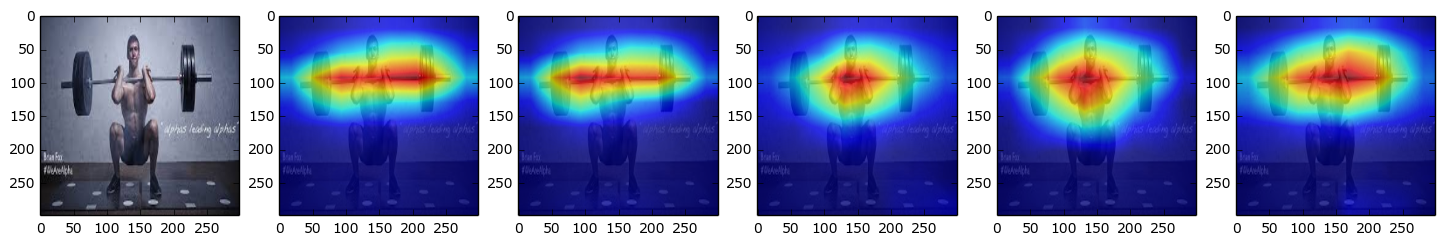

In [98]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 1+top_n, 1)
plt.imshow(rgb)
cam = get_cam(conv_fm, weight_fc[inds_sort, :])
for k in xrange(top_n):
    detection_map = np.squeeze(cam.astype(np.float32)[k, :, :])
    heat_map = cv2.resize(detection_map, (width, height))
    max_response = detection_map.mean()
    heat_map /= heat_map.max()

    im_show = rgb.astype(np.float32)/255*0.3 + plt.cm.jet(heat_map/heat_map.max())[:, :, :3]*0.7
    plt.subplot(1, 1+top_n, k+2)
    plt.imshow(im_show)
    print 'Top %d: %s(%.6f), max_response=%.4f' % (k+1, synset[inds_sort[k]], score_sort[k], max_response)

plt.show()